## Signal to Noise for Q-MIC with gated MPD SPC3 @ 800 nm

Shows coincidence to accidentals ratio (CAR) and total signal to noise ratio (SNR) for
- varying gate windows,
- varying dark counts per pixel,
- different detection efficiencies (total detection efficiency incl. transmission and quantum efficiency): with and without microlens array,
- full sensor vs partial use of sensor.

Also displays corresponding valid pair rate as a function of the above.

In [103]:
# Initialise system values
#-------------------------

import trace as tr
import numpy as np

# target SPDC pair generation rate is 10MHz
pairRate = 1E7

quantEff = 0.05 # SPC3 quantum efficiency at 800nm

optTrans = 0.5 # 50% optical losses
fillFactor = np.array([(30.0**2)/(150.0**2),0.7]) # without and with microlens array (70% fill factor claimed with MLA)
nf = fillFactor.size # number of fillFactor elements
eff = quantEff*optTrans*fillFactor

darkC_ppix = 100 # for >80% of the SPAD pixels dark count is <100cps
numpix = np.array([512,2048]) # focusing on 1/4 of array or using full array
nc = numpix.size # number of pixel configurations

frameRate = 96E3
frameT = 1/frameRate *1E9 # frame period in nanoseconds

ng = 33 # number of gateWin elements
gateWin = np.linspace(1.0,10.0,ng) # different gate windows in nanoseconds
dutyCyc = gateWin/frameT # duty cycles for each gate window (time gate ON vs total length of frame)
probScaler = dutyCyc/frameRate # multiply count rates /s by probScaler to find prob/frame

pairs_psec = pairRate * eff**2 # number of SPDC photon pairs detected by SPAD array per second before gating
darkCSingles_psec = darkC_ppix * numpix # number of dark count singles detected by SPAD array per second before gating
accSingles_psec = pairRate *(eff-eff**2) # number of accidental singles detected by SPAD array per second before gating

#print(pairs_psec.size, darkCSingles_psec.size,accSingles_psec.size)

In [104]:
# Calculate CAR
#--------------

# Apply gating and calculate probabilities (per frame) of coincidences and accidentals
# (need to always have probability of detection << 1 per frame):
# CAR varies with gateWin and with fillFactor , therefore is ng*nf 2D-array
prob_realCoinc = np.tile(probScaler.reshape(ng,1), [1,nf]) * np.tile(pairs_psec, [ng,1]) #prob real SPDC coincidence
prob_accSingle = np.tile(probScaler.reshape(ng,1), [1,nf]) * np.tile(accSingles_psec, [ng,1]) #prob accidental SPDC single photon
prob_accCoinc = prob_accSingle**2 #prob accidental coincidence (from two unpaired SPDC photons)

CAR = prob_realCoinc/prob_accCoinc
#CAR.shape
#print(frameT,frameRate)
#print(pairs_psec)
#print(prob_realCoinc, CAR)

In [105]:
# Calculate full SNR
#-------------------

# Apply gating and calculate probabilities (per frame) for dark counts too:
# darkC varies with gateWin and numpix, therefore prob_darkC are 2D arrays with size ng*nc
prob_darkCSingle = np.tile(probScaler.reshape(ng,1), [1,nc]) * np.tile(darkCSingles_psec,[ng,1]) #prob of dark count single
prob_2darkCoinc = prob_darkCSingle**2 #prob of coincidence from two dark counts

# Probabilities of coincs between SPDC and dark count photons vary with gateWin, fillFactor and numpix
# therefore are 3D arrays with size ng*nf*nc (SNR too)
prob_triple = np.tile(prob_realCoinc.reshape(ng,nf,1),[1,1,nc])* np.tile(prob_darkCSingle.reshape(ng,1,nc),[1,nf,1])
prob_darkAccCoinc = 2 * np.tile(prob_accSingle.reshape(ng,nf,1),[1,1,nc])*np.tile(prob_darkCSingle.reshape(ng,1,nc),[1,nf,1])
                                                                    
prob_signal = np.tile(prob_realCoinc.reshape(ng,nf,1),[1,1,nc]) - prob_triple
prob_noise = np.tile(prob_accCoinc.reshape(ng,nf,1),[1,1,nc]) + prob_darkAccCoinc + np.tile(prob_2darkCoinc.reshape(ng,1,nc),[1,nf,1])

SNR = prob_signal/prob_noise
signalRate = prob_signal * frameRate
#print(SNR.shape,signalRate.shape)
#print(prob_triple)

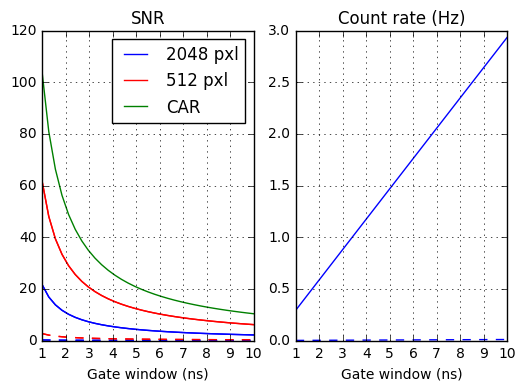

In [106]:
import matplotlib
import matplotlib.pyplot as plt

fig0, [ax0, ax1] = plt.subplots(nrows=1, ncols=2,sharex=True)

ax0.plot(gateWin, SNR[:,0,1],'--b',gateWin, SNR[:,1,1],'b', gateWin, SNR[:,0,0],'--r',gateWin, SNR[:,1,0],'r')

ax0.plot(gateWin, SNR[:,0,1],'--b')#,label = '2048 pxl (bare)')
ax0.plot(gateWin, SNR[:,1,1],'b',label = '2048 pxl')
ax0.plot(gateWin, SNR[:,0,0],'--r')#,label = '512 pxl (bare)')
ax0.plot(gateWin, SNR[:,1,0],'r',label = '512 pxl')
#ax0.plot(gateWin, CAR[:,0],'--g')
ax0.plot(gateWin, CAR[:,1],'g',label = 'CAR')
         
ax0.set(xlabel='Gate window (ns)', title='SNR')
ax0.grid()
ax0.legend()

ax1.plot(gateWin, signalRate[:,0,1],'--b')#,label = 'no MLA') #MLA = microlens array
ax1.plot(gateWin, signalRate[:,1,1],'b')#,label = 'with MLA')
#ax1.plot(gateWin, signalRate[:,0,0],'--r',label = '512 SPADs (bare)')
#ax1.plot(gateWin, signalRate[:,1,0],'r',label = '512 SPADs (MLA)')
ax1.set(xlabel='Gate window (ns)', title='Count rate (Hz)')
ax1.grid()
#ax1.legend()



#fig.savefig("test.png")
plt.show()

(Dashed lines in above figure are for MPD SPC3 sensor without micro-lens array)

Note that:
- Due to the very low quantum efficiency at 800nm (5%), even with micro-lenses the count rate is very low.
- Count rate is (almost) independent of the number of pixels used (given that we change the size of the N00N beam to address a smaller sensor area).
- Using only part of the sensor (512 vs 2048 pixels) increases the SNR as dark counts depends on number of pixels.